


<center><font size="7">Data Analysis - Price Car Behavior</font></center>




<font size="4">Copyright Christophe PERE 01/04/2017</font>

The study is based on data coming from a crawling of sites 'LaCentrale.fr' and 'Leboncoin.fr'. What sort of data ? Autobiz is an enterprise specialised in the pricing of cars at the instant t (now) or t+n (futur). The data crawled are all the information of a car, price, date of circulation, kilometers... So, to understand the behavior of the price depending in time the first analysis consist of ploting the price in funtion of time. 

<span style="color:red"><font size="6">I - Import data </font></span>

Begin your code with the good import modules

In [1]:
%matplotlib inline                          
#%matplotlib notebook                          
# Mandatory in jupyter's notebook if you want to see your plot
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math as M
from scipy.optimize import curve_fit
from time import mktime
#import pandoc

In [2]:
# Let's began with the site 'LaCentrale.fr' and a subdataframe with brands 'PEUGEOT, CITROEN and DS AUTOMOBILES' 
name = '../Docs/Files_FR/Etude_Christophe/car_FR_PSA_lacentrale.csv'
# Open the gzip file and convert all the data in string format, separate the columns with the delimiter ';'
df = pd.read_csv(name+'.gzip', sep=';', dtype=str, compression='gzip')     # load the csv file 

print(df.head())

   data_month MARQUE_CORRECTED  MODELE_CORRECTED CARROSSERIE_CORRECTED  \
0  15/02/2016          CITROEN  C4 GRAND PICASSO             MONOSPACE   
1  15/02/2016          CITROEN  C4 GRAND PICASSO             MONOSPACE   
2  15/02/2016          CITROEN               DS3               BERLINE   
3  15/02/2016          CITROEN               DS5               BERLINE   
4  15/02/2016          CITROEN          BERLINGO             MONOCORPS   

  CARBURANT_CORRECTED LITRE PUISSANCE_CORRECTED BOITE_CORRECTED 4RM   PRIX  \
0              DIESEL   1.6                 112     AUTOMATIQUE   N  10990   
1              DIESEL   1.6                 109        MANUELLE   N  12390   
2              DIESEL   1.6                  92        MANUELLE   N  10990   
3              DIESEL   2.0                 163        MANUELLE   N  23990   
4              DIESEL   1.6                  92        MANUELLE   N  16990   

       KM ANNEE MOIS PORTE_CORRECTED doublon_id_2        site  
0  106786  2011    5  

We can see that the dataframe contains a lot of information. To see the name of the columns we can just use the list container of python. 

In [3]:
head = list(df)                                        # Get the name of the columns 
print(head)                                            # Show the names 

['data_month', 'MARQUE_CORRECTED', 'MODELE_CORRECTED', 'CARROSSERIE_CORRECTED', 'CARBURANT_CORRECTED', 'LITRE', 'PUISSANCE_CORRECTED', 'BOITE_CORRECTED', '4RM', 'PRIX', 'KM', 'ANNEE', 'MOIS', 'PORTE_CORRECTED', 'doublon_id_2', 'site']


In first approximation we just need the columns : MODELE_CORRECTED, PRIX, KM, ANNEE and MOIS. We can simply create a subdataframe with them. Like this : 

In [4]:
df2 = df[[head[2],head[9],head[10],head[11],head[12],head[0]]] # Selection of several columns in the dataframe
head = list(df2)
print(df2.head())                                      # Show the 5 first rows, .tail() to see the last 5 rows 
print('\nThe row number is {}'.format(len(df2)))       # Show the number of row in the dataframe 

   MODELE_CORRECTED   PRIX      KM ANNEE MOIS  data_month
0  C4 GRAND PICASSO  10990  106786  2011    5  15/02/2016
1  C4 GRAND PICASSO  12390   92760  2011    8  15/02/2016
2               DS3  10990  106035  2011   11  15/02/2016
3               DS5  23990   43288  2014    5  15/02/2016
4          BERLINGO  16990    5906  2015    5  15/02/2016

The row number is 899865


The dataframe contains lot of rows rows, each of them correspond to a car. But, we need to create other columns to use the data. First, we need to create the 'Date' columns. How to do this ? It's mandatory to convert columns from string to int or float. Why have we import the dataframe with the dtype 'string' if we need to convert the columns to use them ? The data comes from a cral of the site so the data can have different types. It's easier to import the dataframe with the dtype string to avoid ValueError during the import.

<span style="color:red"><font size="6">II - Data Treatment</font></span>

<span style="color:blue"><font size="5">1 - Date generation </font></span>

Now, you need to convert the columns PRIX, KM, ANNEE and MOIS to create the 'Date' and to clean the data. What is the 'Date' ? It's the moment where the car has been certified. 

In [5]:
def func_treatment(data, head, year):

    pd.options.mode.chained_assignment = None                       # permit to avoid error in copying 
    
    cols = [head[1], head[2],head[3],head[4]]
    for c in cols:
        data[c] = pd.to_numeric(data[c], errors='coerce')           # cast the type str to numeric
        
    # Select a part of the dataframe where the year is > at year passed in the function 
    data = data[(data[head[3]].astype(int)<=datetime.now().year) & (data[head[3]].astype(int)>=year) ]
    data = data[data[head[4]]>0]
    # ---- Date creation --------------------------------------------
    #a = data[head[4]].apply(lambda x : x if x>0 else 1)        # Month can be = 0 when not found in the crawl 
    #data[head[4]]=a.values                                          # so, it's better to fix them at 1 
    a = data[head[4]].apply(lambda x : str(x) if x>=10 else '0'+str(x))# string format and add a 0 when the month is 
    data[head[4]]=a.values                                          # < 10 (01, 02, 03...)
    
    date = data[head[3]].astype(str)+'-'+data[head[4]]  # concat the year-month to generate the Date
    data['Date'] = date.values                                      # .astype() permit to cast a type to another     
                                                                    # passed in the () 
    # ---- Create the age to compare --------------------------------    
    
    data_month = [i.split('/') for i in data.data_month]
    data_month = [i[2]+'-'+i[1] for i in data_month]
    data.data_month=data_month
    size = len(data)
    date_delta=[datetime.strptime(data.data_month.iat[i],'%Y-%m')-datetime.strptime(data.Date.iat[i],'%Y-%m') \
              for i in range(size)]
    #print(date_delta[0].days/30)
    date_age=[round(i.days/30) for i in date_delta] #round
    data['Age_months']=date_age
    data = data[data.Age_months>=0]
    # ---- Data cleaning --------------------------------------------
    a = data[head[0]].fillna(' ')
    data[head[0]] = a.values
    a = data[head[1]].apply(lambda x : x if x>0 else 0 )
    data[head[1]] = a.values
    
    return data


The function 'func_treatment' permit to generate the column 'Date' and clean the data (month = 0, model = NaN ... ). A parameter year is passed to the function, it permit to cut the dataframe and select a time interval between the actual year and a year in the past. 

An important point is to fix a value in the past. 

In [6]:
year_min = 2000                                                      # First year in the subdataframe 

In [7]:
df_treat = func_treatment(df2,list(df2),year_min)
print(df_treat.head())
print(df_treat.tail())

   MODELE_CORRECTED   PRIX      KM  ANNEE MOIS data_month     Date  Age_months
0  C4 GRAND PICASSO  10990  106786   2011   05    2016-02  2011-05          58
1  C4 GRAND PICASSO  12390   92760   2011   08    2016-02  2011-08          55
2               DS3  10990  106035   2011   11    2016-02  2011-11          52
3               DS5  23990   43288   2014   05    2016-02  2014-05          21
4          BERLINGO  16990    5906   2015   05    2016-02  2015-05           9
       MODELE_CORRECTED   PRIX     KM  ANNEE MOIS data_month     Date  \
899860       DS3 CABRIO  21900  12399   2015   03    2017-01  2015-03   
899861              DS4  19490  15864   2015   12    2017-01  2015-12   
899862              DS3  15900  25438   2015   12    2017-01  2015-12   
899863              DS4  25500     12   2015   10    2017-01  2015-10   
899864              DS5  19500   9850   2014   08    2017-01  2014-08   

        Age_months  
899860          22  
899861          13  
899862          13  
899

That's works. Fine, we can now selectionne a model and plot the corresponding data. 

In [8]:
model = 'DS3'                                                    # Car model for the analysis 

In [9]:
# ---- Model's selection ---------------------------------------
head = list(df_treat)
df_model = df_treat[df_treat[head[0]]==model]                    # Select all the row where MODELE_CORRECTED = 'DS3'
print(df_model.head())
print('The row number is {}'.format(len(df_model)))              # Show the number of rows in the dataframe 

   MODELE_CORRECTED   PRIX      KM  ANNEE MOIS data_month     Date  Age_months
2               DS3  10990  106035   2011   11    2016-02  2011-11          52
8               DS3  12500   23860   2012   09    2016-02  2012-09          42
9               DS3  10890   69850   2011   03    2016-02  2011-03          60
20              DS3  19990   10827   2015   04    2016-02  2015-04          10
28              DS3  16990   25636   2015   05    2016-02  2015-05           9
The row number is 34487


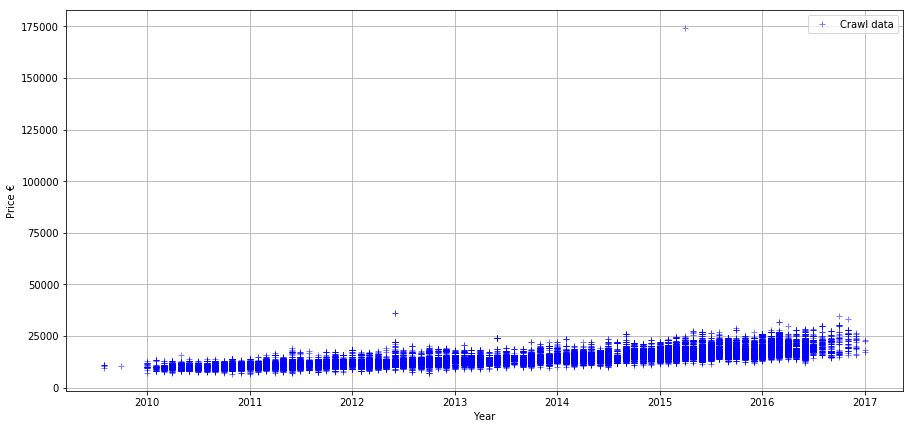

In [10]:
fig = plt.figure(figsize=(15,7))
plt.plot_date(df_model.Date, df_model.PRIX, 'b+', alpha=0.5, label='Crawl data')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

<span style="color:blue"><font size="5">2 - Outliers </font></span>

Like we see, we have outliers in our data, so it's possible to fix a limit in the y axis with ylim() or we can create a function to select a part of the data and remove the outliers. I prefere the second choice, develop a function, the simple reason is the ylim will change with the model and the behavior. 

In [11]:
def func_outliers(data):                                       # remove outliers from data

    years = data[head[3]].unique()                             # list of years unique
    years = list(years)
    years.sort()                                               # sort the list ascending
    t = []
    if(len(years)<3):                                          # if we have 1 or 2 years we take all the data
        return data
    for i in years :
        df = data[data[head[3]]==i]                            # select a subdataframe by year
        months = df[head[4]].unique()                          # return a list of month
        for j in months:
            df2 = df[df[head[4]]==j]                           # select a subsubdataframe by month in the year
            mean = df2[head[1]].median(axis=0)                 # compute the median of the price for the month
            std  = df2[head[1]].std(axis=0)                    # compute the standard deviation
            df_fin = df2[(df2[head[1]] < (mean+ 3* std)) ]     # select price in the interval median+/-2std
            df_fin = df_fin[(df_fin[head[1]]>(mean-3*std))]
            t.append(df_fin)                                   # create a list of subsubdataframe
        d = pd.concat(t, axis=0)                               # create a final dataframe of the points without 
                                                               # outliers
    d = d.drop_duplicates(d[['PRIX','KM','Date']],keep='last')
    d = d[d.KM<200000]
    return d

In [12]:
df_select = func_outliers(df_model)
print('The initial size was {} and the final size is {} rows'.format(len(df_model), len(df_select)))

The initial size was 34487 and the final size is 19151 rows


Good news, the data have been cleared. Time to be ploted !

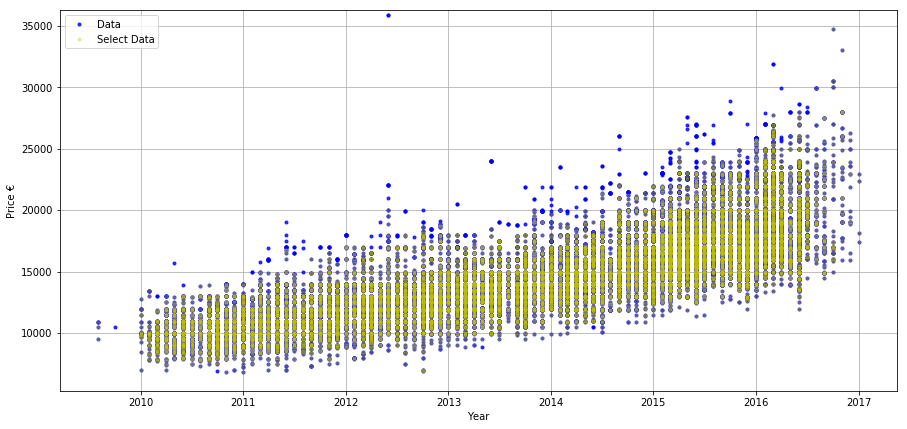

In [13]:
fig = plt.figure(figsize=(15,7))
plt.plot_date(df_model.Date, df_model.PRIX, 'b.', alpha=0.8, label='Data')
plt.plot_date(df_select.Date, df_select.PRIX, 'y.', alpha=0.3, label='Select Data')
plt.ylim(df_select.PRIX.min()-1500, df_select.PRIX.max()+1500)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

An interesting banana appears. The data are not totaly useful in this stack. This is totaly normal because we have several cars in the same month. Maybe if we had access to the day of the certification the spread will be different. 

<span style="color:blue"><font size="5">3 - Mean - Median and projected values </font></span>

Netherless, we can bypassing this problem by compute the mean or the median per month and plot them. To simplify this, we can create a function :

In [14]:
def func_mean_median(data, name):
    # ---- Mean Median computation --------------------------
    
    mean     = []                                # Empty list to stock the results of the computation
    median   = []
    err      = []
    km_value = []
    months   = []
    for i in data[name].unique():
        d  = data[data[name]==i]              # Select a subdataframe by date
        z  = d[head[1]].mean(axis=0)         # Compute the mean of the price
        z4 = d[head[1]].std(axis=0)          # Compute the standard deviation of the price 
        z2 = d[head[1]].median(axis=0)       # Compute the median of the price
        z3 = d[head[2]].mean(axis=0)         # Compute the mean of the kilometer
        #months.append(d.Age_months.mean(0))  # Save the corresponding month
        mean.append(z)                       # Save the values in the lists 
        median.append(z2)
        err.append(z4)
        km_value.append(z3)
        
    dict_values = { name       :pd.Series(np.array(df_select[name].unique())),
                   'Mean'      :pd.Series(np.array(mean)),
                   'Median'    :pd.Series(np.array(median)),
                   'Error'     :pd.Series(np.array(err))}#,
                   #'Age_months':pd.Series(np.array(months))}
    # Pass from dict to dataframe by specifying the name of the columns - correspond to the columns' order
    df_results = pd.DataFrame(columns = [name, 'Mean','Median','Error'],data=dict_values)


    return df_results


Now, test it :

In [15]:
df_results  = func_mean_median(df_select, 'Date')
print('The first point is : real={}€ mean={}€ median={}€ std={}€'\
      .format(int(df_select[head[1]].iat[len(df_select)-1]),int(df_results.Mean.iat[len(df_results)-1]),\
              int(df_results.Median.iat[len(df_results)-1]), '%.2f'%df_results.Error.iat[len(df_results)-1]))

The first point is : real=18100€ mean=20200€ median=20250€ std=2850.73€


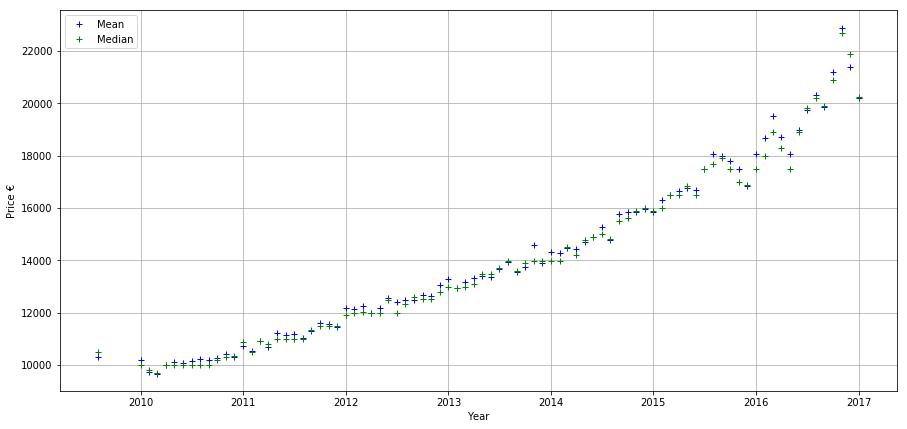

In [16]:
fig = plt.figure(figsize=(15,7))
plt.plot_date(df_select.Date.unique(), df_results.Mean, 'b+', label='Mean')
plt.plot_date(df_select.Date.unique(), df_results.Median, 'g+', label='Median')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

Perfect, we have the price's behavior of a model in function of time. The mean/median computation allows to place the model at a standard kilometer. It will be interested to understand the scattering of the data per month. We'll do it soon. 
The next step is to reverse the data. The goal is to determine the future value of the car. To do this, it's interesting to fit the data with different approaches. Let's do it. 

The result is interesting but, the columns Date is not sorted. 

In [17]:
df_results = df_results.sort_values(by='Date')             # sort the dataframe by date
print(df_results.head())

       Date          Mean   Median        Error
0   2009-08  10290.000000  10480.0   714.212853
5   2010-01  10176.470588   9990.0  1342.469465
12  2010-02   9728.709677   9800.0  1204.363572
7   2010-03   9670.449275   9700.0   926.760067
11  2010-04   9980.720000   9990.0  1186.121607


Great, the dataframe is sorted by Date, but for the moment we haven't reverse the data. 

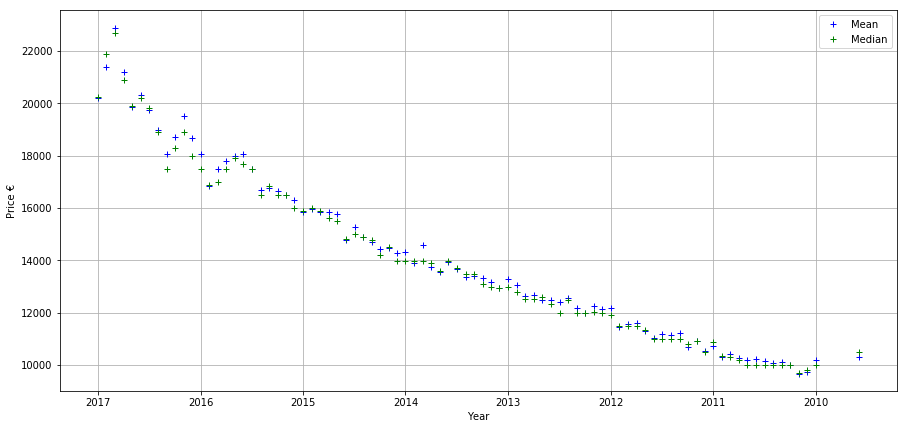

In [18]:
fig = plt.figure(figsize=(15,7))
plt.gca().invert_xaxis()                                              # allows to reverse the graph 
plt.plot_date(df_results.Date, df_results.Mean, 'b+', label='Mean')
plt.plot_date(df_results.Date, df_results.Median, 'g+', label='Median')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

Ok, the data are reversed but, the x axis doesn't correspond to future dates. Next, create a new columns with the new dates projected in the futur.  

In [19]:
def func_reverse(df_results):
    size = len(df_results)-1                                      # Stock the length -1 in a variable 
    # save the time_delta between to successive dates 2012-01 - 2013-01 --> 365 days
    date_delta=[datetime.strptime(df_results.Date[size-i],'%Y-%m')\
                -datetime.strptime(df_results.Date[size-i-1],'%Y-%m')\
                for i in range(len(df_results.Date)-1)]
    date = list(np.ones(len(date_delta)+1))                       # Generate a list with all values = 1
    date[0]=datetime.strptime(df_results.Date.iat[size], '%Y-%m') # initialise the list with the last value in the 
                                                                  # initial date

    for i in range(len(date_delta)):                              # Loop to create the new date with the time_delta
         date[i+1]=date[i]+date_delta[i]

    # Transform the new date %Y-%m
    new_date = [str(i.year)+'-'+str(i.month) if i.month>=10 else str(i.year)+'-0'+str(i.month) for i in date]   
    new_date.sort()
    df_results['New_date']=new_date[::-1]                         # Create new columns in the dataframe 
    
    # convert the date in days (since the 1970-01-01, Unix time)
    x_new = [mktime(datetime.strptime(i, '%Y-%m').timetuple())/86400 for i in df_results.New_date ]
    x_new = [i - x_new[len(x_new)-1] for i in x_new]          # Now pass the origin to x = 0 
    x_new.sort()
    df_results['Unix_day']=x_new[::-1]
    
    return df_results

Time to see if all the manipulation works. 

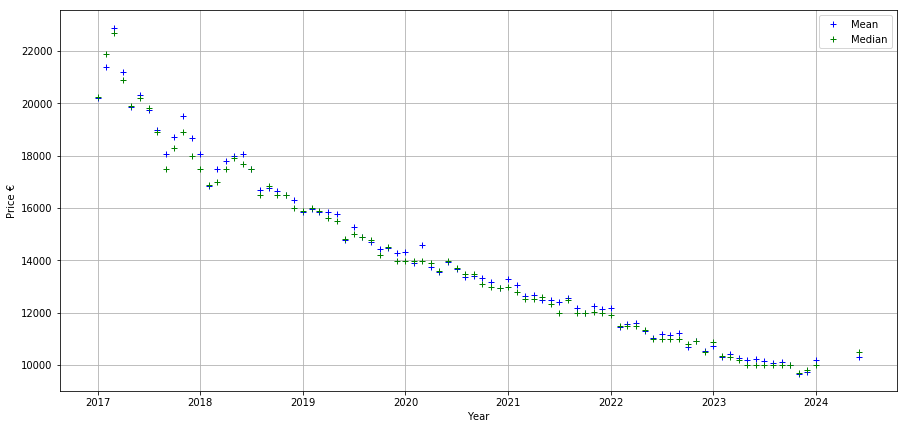

In [20]:
df_results2 = func_reverse(df_results)
fig = plt.figure(figsize=(15,7))
plt.plot_date(df_results2.New_date, df_results2.Mean, 'b+', label='Mean')
plt.plot_date(df_results2.New_date, df_results2.Median, 'g+', label='Median')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

All right, we have a new dataset and the corresponding dates. 

<span style="color:red"><font size="4">All of this is in the first hypothesis that the car will be the same behavior than the one observe during the crawl.</font></span> 

<span style="color:blue"><font size="5">4 - Age reference</font></span>

The date can be a source of problems if we study data with a time series variations in the crawl. If a car is observe in the first month of one year and the last month of the same year, it appear a bias of 11months between them. To place correctly the data point, a correct method wiil be to use the age of the car when it observes. 

The function treatment received a modification to compute the age of the car at the moment of the crawl. The mean/median function take in arguments the name of the column reference. 

In [21]:
df_results  = func_mean_median(df_select, 'Age_months')
print(df_results.head())

   Age_months          Mean   Median        Error
0          81   9376.363636   9045.0   938.162061
1          82   9958.076923   9945.0  1417.030753
2          87   9500.000000   9500.0          NaN
3          65  10792.169312  10790.0  1275.944378
4          66  10616.965116  10500.0  1443.922326


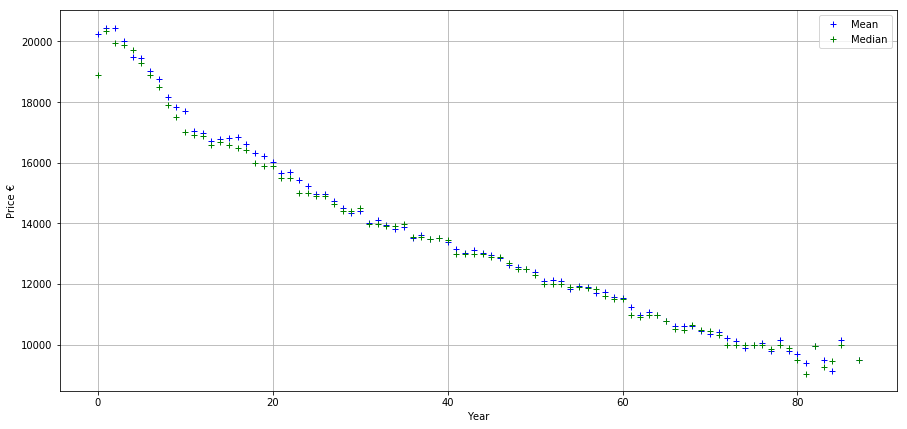

In [22]:
#df_results = func_reverse(df_results)
fig = plt.figure(figsize=(15,7))
plt.plot(df_results.Age_months, df_results.Mean, 'b+', label='Mean')
plt.plot(df_results.Age_months, df_results.Median, 'g+', label='Median')
#plt.plot(df_results., df_results.Mean, 'b+', label='Mean')
#plt.plot(df_results.Age_months*30, df_results.Median, 'g+', label='Median')


plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

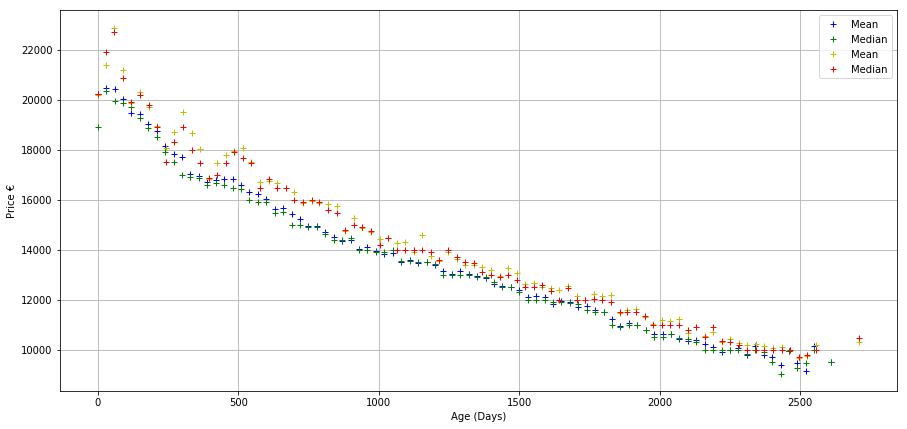

In [23]:
fig = plt.figure(figsize=(15,7))
plt.plot(df_results.Age_months*30, df_results.Mean, 'b+', label='Mean')
plt.plot(df_results.Age_months*30, df_results.Median, 'g+', label='Median')
plt.plot(df_results2.Unix_day, df_results2.Mean, 'y+', label='Mean')
plt.plot(df_results2.Unix_day, df_results2.Median, 'r+', label='Median')


plt.legend()
plt.xlabel('Age (Days)')
plt.ylabel('Price €')
plt.grid(True)

<span style="color:red"><font size="5">III - Regression Models</font></span>

It's time to begin the fun part. After cleaning the data we are able to use it. 

<span style="color:blue"><font size="4">1 - Exponential model</font></span>

The first approach chosen is an exponential negative. Why ? Because, in the most cases, the data decrease de façon exponential so, naturaly, this method was chosen to experiment mathematically the behavior. 

The packages Numpy and Scipy have a function to fit a dataset with an equation. The Numpy function is polyfit (generally use to fit with a polynomial approach but can be test with the log() function ~linear approach of the data) and the Scipy function is curve_fit, it's a least square method and can be apply for all needed function). 

In [24]:
def func_fitexp(x, y):                                      
    res = np.polyfit(x, np.log(y), 1,w=np.sqrt(y))
    res_tot = np.exp(res[1])*np.exp(res[0]*x)
    return res_tot, res

def func_exp(x, y):
    res_fit = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(20000, 1e-6))
    #print(res_fit[0])
    return res_fit[0][0] * np.exp(res_fit[0][1] * x)

After various tests, the choice is inclined to use the polyfit method. But, we can not experiment this technique with date number. Create a new axis :

Simple method to conserve the delta in date with array data. Now, test our first model. It will be interesting to compare the fit between the median and the mean for the polynomial approach and the exponential approach. The results will be added to the dataframe, with this method, all the data will be in the same place.

In [25]:
#y_exp_mean, coeffs= func_fitexp(df_results.New_date, df_results.Mean)      # Call of the function to fit the 
#y_exp_median, coeffs= func_fitexp(df_results.New_date, df_results.Median)  # exponential with the data
y_exp_mean, coeffs= func_fitexp(df_results.Age_months, df_results.Mean)      # Call of the function to fit the 
y_exp_median, coeffs= func_fitexp(df_results.Age_months, df_results.Median)  # exponential with the data
df_results['y_exp_median'] = y_exp_median                                  # Save the results in the dataframe  
df_results['y_exp_mean']   = y_exp_mean

So we have compute the mean and median fits, the next figure will show the different results. 

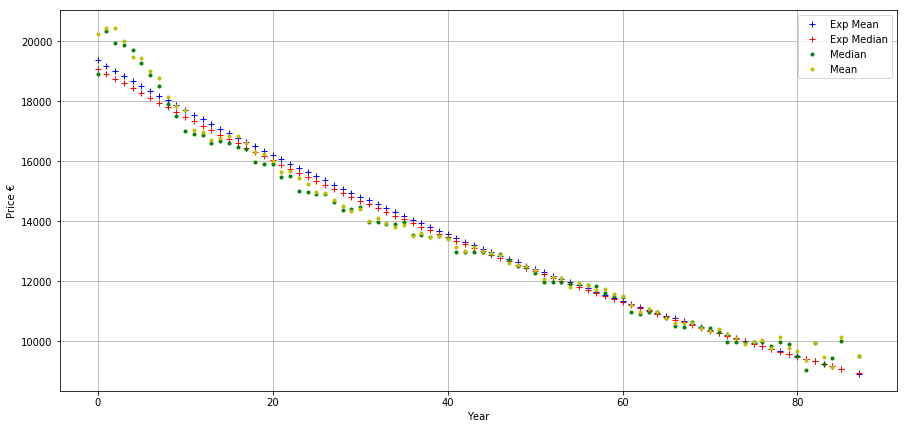

In [26]:
fig = plt.figure(figsize=(15,7))
#plt.plot(df_results.New_date, df_results.y_exp_mean, 'b+', label='Exp Mean')
plt.plot(df_results.Age_months, df_results.y_exp_mean, 'b+', label='Exp Mean')
plt.plot(df_results.Age_months, df_results.y_exp_median, 'r+', label='Exp Median')
plt.plot(df_results.Age_months, df_results.Median, 'g.', label='Median')
plt.plot(df_results.Age_months, df_results.Mean, 'y.', label='Mean')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

For this model, the difference can be negligible. But, if we compare the first value, the difference can be more important for a different model.

In [27]:
mean_origin   = df_results.y_exp_mean.iat[len(df_results)-1]
median_origin = df_results.y_exp_median.iat[len(df_results)-1]
print('The origin for the exp mean is {}€ and for the median {}€'.format(int(mean_origin), int(median_origin)))
print('The difference correspond to a variation of {}% or {}€'\
      .format('%.2f'%(100*abs(mean_origin-median_origin)/mean_origin),int(abs(mean_origin-median_origin))))

#For the model=C3
#The Result if the column New_date is used is : 
#The origin for the exp mean is 13929€ and for the median 13817€
#The difference correspond to a variation of 0.81% or 112€
#The Result if the column Age_months is used is : 
#The origin for the exp mean is 13234€ and for the median 13148€
#The difference correspond to a variation of 0.65% or 86€

The origin for the exp mean is 19362€ and for the median 19089€
The difference correspond to a variation of 1.41% or 272€


<i><b>Aparte</b></i>

We can compare the two exponential functions (Numpy and Scipy approach) to see if we found a big difference between both. 

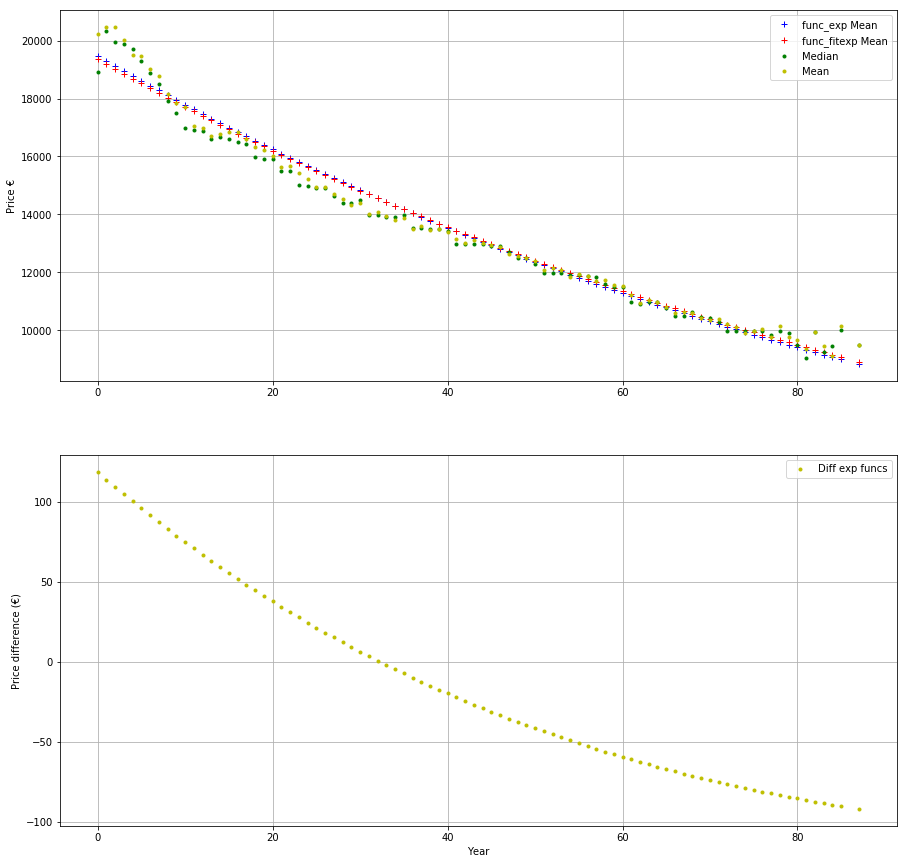

In [28]:
y_func_exp = func_exp(df_results.Age_months, df_results.Mean)          # New y values Scipy method
#y_func_exp = func_exp(df_results.New_date, df_results.Mean)          # New y values Scipy method

fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(211)
#plt.plot_date(df_results.New_date, y_func_exp, 'b+', label='func_exp Mean')
plt.plot(df_results.Age_months, y_func_exp, 'b+', label='func_exp Mean')
plt.plot(df_results.Age_months, df_results.y_exp_mean, 'r+', label='func_fitexp Mean')
plt.plot(df_results.Age_months, df_results.Median, 'g.', label='Median')
plt.plot(df_results.Age_months, df_results.Mean, 'y.', label='Mean')
plt.legend()
#plt.ylim(0, 1e5)
plt.ylabel('Price €')
plt.grid(True)
ax2 = plt.subplot(212, sharex=ax1)
plt.plot_date(df_results.Age_months, y_func_exp-df_results.y_exp_mean , 'y.', label='Diff exp funcs')
plt.legend()
#plt.ylim(0, 1e5)
plt.xlabel('Year')
plt.ylabel('Price difference (€)')
plt.grid(True)

The max difference between the two method is

In [29]:
print('{}€'.format(int(max(y_func_exp-df_results.y_exp_mean))))

118€


<b><i>End of the Aparte </i></b>

<span style="color:blue"><font size="4">2 - Polynomial model</font></span>

In [30]:
def func_polyfit(df_results, deg):
    """
        Function polyfit of numpy to generate a polynomial fit with a degree deg 
        x             : x axis
        value_mean    : mean of the data
        value_median  : median of the data
        deg           : degree of the polynomial fit
        return        : y, y2, (x, y) coordinates
    """
    df_results = df_results[df_results.Mean.notnull()]
    #x                 = df_results.Unix_day
    x                 = df_results.Age_months
    value_mean        = df_results.Mean
    value_median      = df_results.Median
    
    coeff_mean_poly   = np.polyfit(x, value_mean, deg)         # exponential fit on the mean data
    coeff_median_poly = np.polyfit(x, value_median, deg)       # exponential fit on the median data
    p  = np.poly1d(coeff_mean_poly)                            # poly1d is the associative function with polyfit
    p2 = np.poly1d(coeff_median_poly)
    
    #print(test, test2)
    y_poly_mean   = p(x)                                       # Compute new y value with the mean data
    y_poly_median = p2(x)                                      # Compute new y value with the median data
    df_results['y_poly_mean']   = y_poly_mean
    df_results['y_poly_median'] = y_poly_median
    
    return df_results, coeff_mean_poly, coeff_median_poly 


The function above group the fit, the polynomial function resulting of the fit and the new corresponding y for the mean and the median. 

In [31]:
df_results, coeff_mean, coeff_median = func_polyfit(df_results, 3)
#y_poly_mean, y_poly_median, coeff_mean, coeff_median = func_polyfit(df_results.Unix_day, df_results.Mean, \
#                                                                    df_results.Median, 3)
#df_results['y_poly_mean']=y_poly_mean
#df_results['y_poly_median']=y_poly_median

origin_mean   = coeff_mean[len(coeff_mean)-1]
origin_median = coeff_median[len(coeff_median)-1]
print('The polynomial mean fit is :')
print(np.poly1d(coeff_mean))
print('\nThe polynomial median fit is :')
print(np.poly1d(coeff_median))
print('\nx is in days from the origin - 12 months - correspond to x = 365')
print('\nThe initial difference is {}€ whether {}%'.format(int(abs(origin_mean-origin_median)), \
                                                           '%.2f'%(100*abs(origin_mean-origin_median)/origin_median)))

The polynomial mean fit is :
         3        2
-0.0163 x + 3.16 x - 282 x + 2.044e+04

The polynomial median fit is :
          3         2
-0.01411 x + 2.764 x - 259.5 x + 2e+04

x is in days from the origin - 12 months - correspond to x = 365

The initial difference is 446€ whether 2.23%


In the previous exemple we have computed an exponential model, now a polynomial model, it will be interesting to compare both. The next figure will show the different fits. 

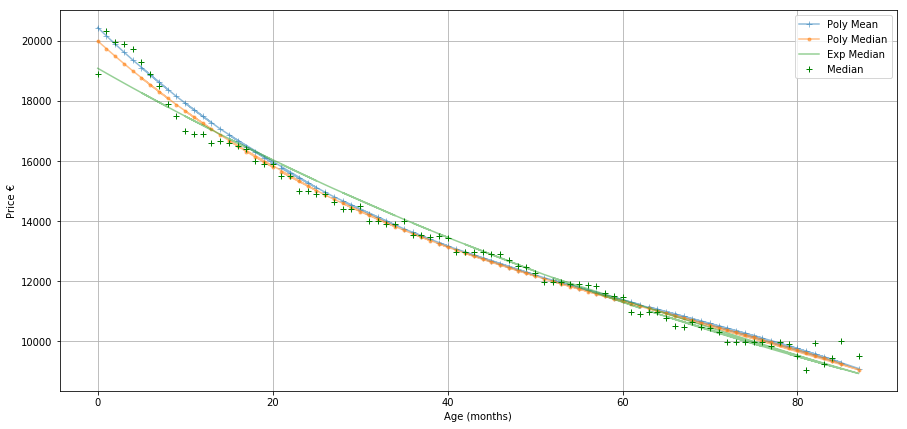

In [32]:
fig = plt.figure(figsize=(15,7))
#plt.plot_date(df_results.New_date, df_results.y_poly_mean, '+-',alpha=0.5, label='Poly Mean')
plt.plot(df_results.Age_months, df_results.y_poly_mean, '+-',alpha=0.5, label='Poly Mean')
plt.plot(df_results.Age_months, df_results.y_poly_median, '.-',alpha=0.5, label='Poly Median')
plt.plot(df_results.Age_months, df_results.y_exp_median, '-',alpha=0.5, label='Exp Median')
plt.plot(df_results.Age_months, df_results.Median, 'g+', label='Median')
plt.legend()
plt.xlabel('Age (months)')
plt.ylabel('Price €')
plt.grid(True)

Like we can see, the polynomial fit seems to bit the best candidat when we have lot of data but when the dataset become poor the exponential allows to compute a decrease without peak or deviant behavior. 

When we work on car market, we need to now the price decrease call devaluation per year. To do that, the next function separate the dataframe in subdataframe to isolate data per year and to compute the devaluation (%) on the year. 

In [33]:
def func_annual_devalo(data,name):            # remove outliers from data
    #data = data.drop_duplicates('Date_test')
    #data['Median']=y
    #data = data.sort_values(by='Date_test')
    liste = []
    annee = [datetime.strptime(i, '%Y-%m').year for i in data.New_date]
    
    data['annee']=annee
    #print(data.head(10))
    for i in data.annee.unique() :
        df = data[data.annee==i]
        #print(df)
        devalo = 100*(df[name].iat[len(df)-1] - df[name].iat[0])/df[name].iat[len(df)-1]
        #print(df.Median.iat[0], df.Median.iat[len(df)-1])
        liste.append(devalo)
    return liste, data


In [34]:
print(df_results.head())

   Age_months          Mean   Median        Error  y_exp_median    y_exp_mean  \
0          81   9376.363636   9045.0   938.162061   9410.461674   9417.267197   
1          82   9958.076923   9945.0  1417.030753   9328.643818   9333.839816   
2          87   9500.000000   9500.0          NaN   8930.101940   8927.659047   
3          65  10792.169312  10790.0  1275.944378  10821.554069  10858.196200   
4          66  10616.965116  10500.0  1443.922326  10727.467680  10762.003657   

    y_poly_mean  y_poly_median  
0   9672.918972    9618.279363  
1   9581.158694    9528.169422  
2   9094.898548    9054.701361  
3  10989.661087   10936.698489  
4  10911.803285   10857.711972  


In [35]:
def func_annual_devalo2(data,name):            # remove outliers from data
    #data = data.drop_duplicates('Date_test')
    #data['Median']=y
    data = data.sort_values(by='Age_months')
    liste = []
    annee = np.arange(round(data.Age_months.max()/12))
    frame = []
    #print(annee)
    #data['annee']=annee #+datetime.now().year
    #print(data.head(10))
    for i in range(len(annee)) :
        if(i<len(annee)-1):
            df = data[(data.Age_months >=(i * 12)) &  (data.Age_months < ((i+1) * 12) )]
            if(len(df)<1):
                continue
        #df = data[data.annee==i]
        #print(df)
            df['annee']=i
            #print(i)
            #print(df.annee)
            frame.append(df)
            devalo = 100*(df[name].iat[0] - df[name].iat[len(df)-1])/df[name].iat[0]
        #print(df.Median.iat[0], df.Median.iat[len(df)-1])
            liste.append(devalo)
        else:
            df = data[(data.Age_months >=(i * 12))]
            if(len(df)<1):
                continue
        #df = data[data.annee==i]
            #print(i)
        #print(df)
            df['annee']=i
            frame.append(df)
            devalo = 100*(df[name].iat[0] - df[name].iat[len(df)-1])/df[name].iat[0]
        #print(df.Median.iat[0], df.Median.iat[len(df)-1])
            liste.append(devalo)
    #print(frame)    
    df = pd.concat(frame, axis=0)
    #print(df)
    return liste, df



Use it on the different fit results (exponential and polynomial on the mean and median data). 

In [36]:
devalo_poly_mean, df_modif_poly = func_annual_devalo2(df_results, 'y_poly_mean')
devalo_poly_median, df_modif_poly = func_annual_devalo2(df_results, 'y_poly_median')
devalo_exp_mean, df_modif_poly = func_annual_devalo2(df_results,  'y_exp_mean')
devalo_exp_median, df_modif_poly = func_annual_devalo2(df_results,  'y_exp_median')

The corresponding visualisation. 

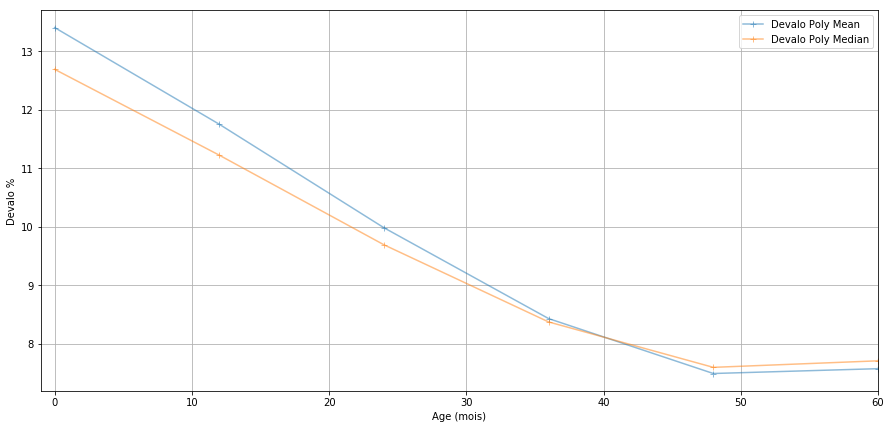

In [37]:
fig = plt.figure(figsize=(15,7))
plt.plot(df_modif_poly.annee.unique()*12, devalo_poly_mean, '+-',alpha=0.5, label='Devalo Poly Mean')
plt.plot(df_modif_poly.annee.unique()*12, devalo_poly_median, '+-',alpha=0.5, label='Devalo Poly Median')
#plt.plot(df_modif_poly.annee.unique()*12, devalo_exp_mean, '.-',alpha=0.5, label='Devalo Exp Mean')
#plt.plot(df_modif_poly.annee.unique()*12, devalo_exp_median, '.-',alpha=0.5, label='Devalo Exp Median')
plt.legend()
plt.xlim(-1,60)
plt.xlabel('Age (mois)')
plt.ylabel('Devalo %')
plt.grid(True)

Why the difference ? If you compute the devaluation with an exponential the devalutation is constant. This is not the case with a polynomial approach (3rd degree). 

<span style="color:blue"><font size="4">3 - Gaussian model ? </font></span>

I'm curious to see if we could make an approximation with a gaussian for this data. So make a function to use a gaussian. The fit will be generate with the curve_fit library of the Scipy package. 

In [38]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Tester avec la fonction des microlentilles 

In [39]:
'''x_test = list(df_results.Unix_day)                              # Generate a x,y sample 
y_test = list(df_results.Mean)
x_test.sort()
y_test.sort()
delta = [x_test[i]-x_test[0] for i in range(len(x_test))]
x_test2 = np.array(x_test[::-1] + [x_test[len(x_test)-1] + i for i in delta[::-1]])
y_test2 = np.array(list(df_results.Mean) + list(df_results.Mean[::-1]))

mean_test = sum(x_test2*y_test2)/len(x_test2)                # Calcul a mean and sigma value
sigma = sum(y_test2*(x_test2 - mean_test)**2)/len(x_test2)
print(mean_test, sigma)
popt, pcov = curve_fit(gauss_function, x_test2, y_test2, p0 = [1, mean_test, sigma]) # make the fit

fig = plt.figure(figsize=(15,7))
plt.plot(x_test2, gauss_function(x_test2, *popt), label='fit')
#plt.plot_date(df_results.New_date, df_results.Mean, 'g+', label='Median')
plt.plot(x_test2, y_test2, 'g+', label='Median')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)'''

"x_test = list(df_results.Unix_day)                              # Generate a x,y sample \ny_test = list(df_results.Mean)\nx_test.sort()\ny_test.sort()\ndelta = [x_test[i]-x_test[0] for i in range(len(x_test))]\nx_test2 = np.array(x_test[::-1] + [x_test[len(x_test)-1] + i for i in delta[::-1]])\ny_test2 = np.array(list(df_results.Mean) + list(df_results.Mean[::-1]))\n\nmean_test = sum(x_test2*y_test2)/len(x_test2)                # Calcul a mean and sigma value\nsigma = sum(y_test2*(x_test2 - mean_test)**2)/len(x_test2)\nprint(mean_test, sigma)\npopt, pcov = curve_fit(gauss_function, x_test2, y_test2, p0 = [1, mean_test, sigma]) # make the fit\n\nfig = plt.figure(figsize=(15,7))\nplt.plot(x_test2, gauss_function(x_test2, *popt), label='fit')\n#plt.plot_date(df_results.New_date, df_results.Mean, 'g+', label='Median')\nplt.plot(x_test2, y_test2, 'g+', label='Median')\nplt.legend()\nplt.xlabel('Year')\nplt.ylabel('Price €')\nplt.grid(True)"

Like we can see, the gaussian approach failed. 

<span style="color:red"><font size="5">IV - Cause of the data scattering</font></span>

If you go back to the second plot of the data (after outliers cleaning) you'll see the data sample and the associated scattering. Let us interest ourselves in this dispersion in order to try to understand what composes it. 

<span style="color:blue"><font size="4">1 - Kilometers </font></span>

It's normal to think <i>a posteriori</i> that the kilometers should have an important impact on the price. So the first study on the scattering will be to see the effect of the kilometers. To understand the scattering, the next step  consist off plotting the kilometers in function of the price. If we'll see a correlation between them that will imply that this parameter is important. 

In [40]:
df_scatter       = df_select[df_select.Age_months==0]
df_scatter1      = df_select[df_select.Age_months==6]
df_scatter2      = df_select[df_select.Age_months==12]
df_scatter3      = df_select[df_select.Age_months==18]
median_km_age    = df_scatter.KM.median()
median_prix_age  = df_scatter.PRIX.median()
median_km_age1   = df_scatter1.KM.median()
median_prix_age1 = df_scatter1.PRIX.median()
median_km_age2   = df_scatter2.KM.median()
median_prix_age2 = df_scatter2.PRIX.median()
median_km_age3   = df_scatter3.KM.median()
median_prix_age3 = df_scatter3.PRIX.median()
print('Age {} months : ({}km, {}€)'.format(df_scatter.Age_months.iat[0],int(median_km_age),int(median_prix_age)))
print('Age {} months : ({}km, {}€)'.format(df_scatter1.Age_months.iat[0],int(median_km_age1),int(median_prix_age1)))
print('Age {} months : ({}km, {}€)'.format(df_scatter2.Age_months.iat[0],int(median_km_age2),int(median_prix_age2)))
print('Age {} months : ({}km, {}€)'.format(df_scatter3.Age_months.iat[0],int(median_km_age3),int(median_prix_age3)))

Age 0 months : (12km, 18900€)
Age 6 months : (2780km, 18887€)
Age 12 months : (15135km, 16890€)
Age 18 months : (18735km, 15990€)


We have select four dates covering 18months, plot them. 

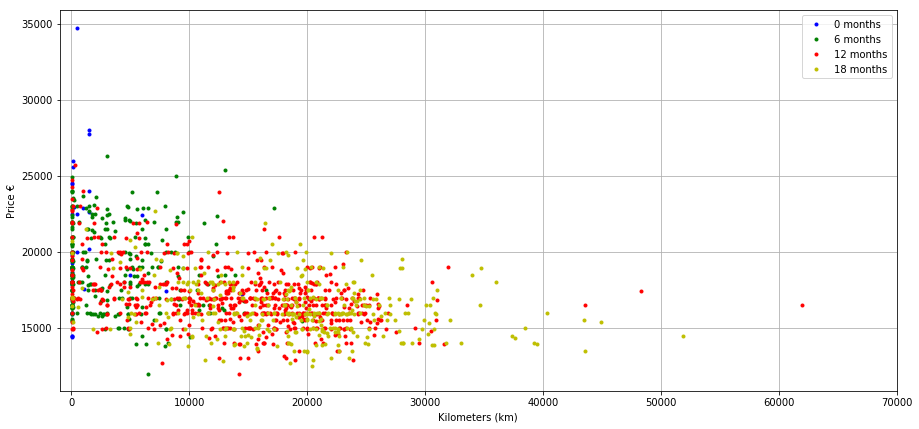

In [41]:
fig = plt.figure(figsize=(15,7))
plt.plot(df_scatter.KM , df_scatter.PRIX , 'b.', label=str(df_scatter.Age_months.iat[0])+' months')
plt.plot(df_scatter1.KM, df_scatter1.PRIX, 'g.', label=str(df_scatter1.Age_months.iat[0])+' months')
plt.plot(df_scatter2.KM, df_scatter2.PRIX, 'r.', label=str(df_scatter2.Age_months.iat[0])+' months')
plt.plot(df_scatter3.KM, df_scatter3.PRIX, 'y.', label=str(df_scatter3.Age_months.iat[0])+' months')
plt.xlim(-1000,70000)
plt.legend()
plt.xlabel('Kilometers (km)')
plt.ylabel('Price €')
plt.grid(True)

The results are not blatant. The comparaison between this four dates can't bring to conclude that the kilometers as a strong impact on the price. 

<span style="color:blue"><font size="4">2 - Versioning </font></span>

For the moment, the study was based on one parameter, the <i>model</i> of the car. Now, the goal is to see the behavior when we take into account more than one. 

Restart from the beginning. 

In [42]:
print(list(df))

['data_month', 'MARQUE_CORRECTED', 'MODELE_CORRECTED', 'CARROSSERIE_CORRECTED', 'CARBURANT_CORRECTED', 'LITRE', 'PUISSANCE_CORRECTED', 'BOITE_CORRECTED', '4RM', 'PRIX', 'KM', 'ANNEE', 'MOIS', 'PORTE_CORRECTED', 'doublon_id_2', 'site']


Make a selection of a subdataframe corresponding to the caracteristics of the car. 

In [43]:
df_carac = df[['MODELE_CORRECTED', 'PRIX', 'KM', 'ANNEE', 'MOIS','CARROSSERIE_CORRECTED', \
               'CARBURANT_CORRECTED', 'LITRE', 'PUISSANCE_CORRECTED', 'BOITE_CORRECTED',  \
               '4RM',  'PORTE_CORRECTED','data_month']]
head = list(df_carac)
df_model = df_carac[df_carac[head[0]]==model]           # select a subdataframe with the model pass in part II
#print(df_model.head())
df_model = func_treatment(df_model,head,year_min)                    # make the treatment of the subdataframe

<span style="color:green"><font size="3"><i>a - Model & car body </i></font></span>

The first approach is to join the car body (berline, societe, 4x4...) of the model to the analysis.  

The initial size was 34487 and the final size is 19151 rows 



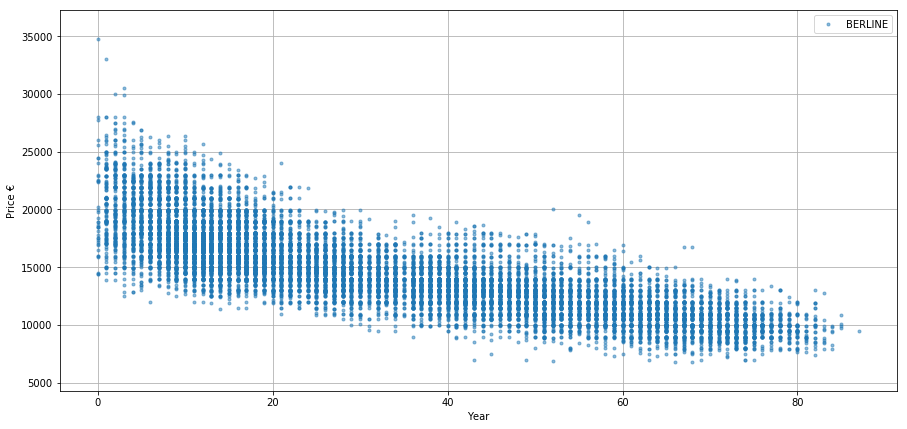

In [44]:
#df_model = func_treatment(df_model,head,year_min)                    # make the treatment of the subdataframe
df_carbody = func_outliers(df_model)                                 # clean the data
print('The initial size was {} and the final size is {} rows \n'.format(len(df_model), len(df_carbody)))
carbody = df_carbody[head[5]].unique()                               # make a list of all the car body types

# ---- Plot the result ------------------------------------------------------

fig = plt.figure(figsize=(15,7))
#plt.plot(df_model.Age_months, df_model.PRIX, 'b+', alpha=0.8, label='Data')
for i in carbody:                                                    # loop on the car body 
    if type(i)==str:                                                 # test on the type, if nan appear -> np.float64
        df_carbody1 = df_carbody[df_carbody[head[5]]==i]             # select the subsubdataframe
    else:
        df_carbody1 = df_carbody[df_carbody[head[5]].isnull()]       # select all the nan rows 
    plt.plot(df_carbody1.Age_months, df_carbody1.PRIX,  '.', alpha=0.5, label=i)
plt.ylim(df_carbody.PRIX.min()-2500, df_carbody.PRIX.max()+2500)     # resize the figure 
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

The figure show that the car body as no impact on the price or the behavior. 

<span style="color:green"><font size="3"><i>b - Model & fuel </i></font></span>

The second approach is to join the fuel (Essence, diesel...) of the model to the analysis.  

The initial size was 34487 and the final size is 19151 rows 



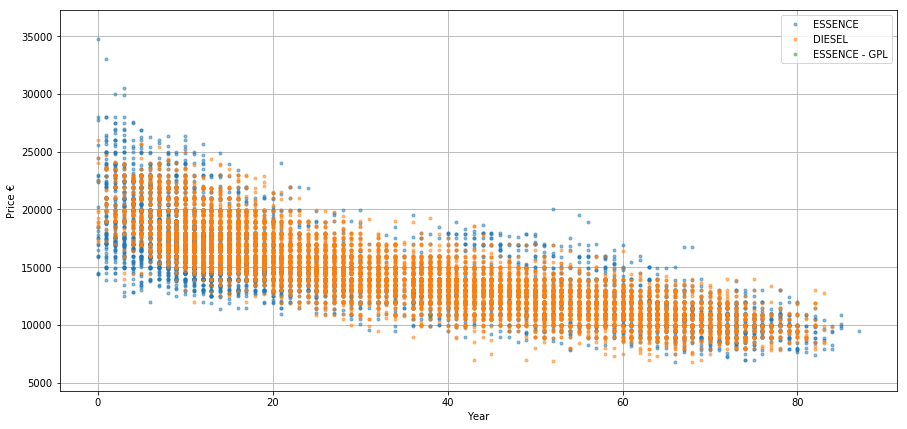

In [45]:
#df_model = func_treatment(df_model,head,year_min)                    # make the treatment of the subdataframe
df_fuel = func_outliers(df_model)                                    # clean the data
print('The initial size was {} and the final size is {} rows \n'.format(len(df_model), len(df_fuel)))
fuel = df_fuel[head[6]].unique()                                     # make a list of all the fuel types

# ---- Plot the result ------------------------------------------------------

fig = plt.figure(figsize=(15,7))
#plt.plot_date(df_model.Date, df_model.PRIX, 'b+', alpha=0.8, label='Data')
for i in fuel:                                                       # loop on the fuel    
    if type(i)==str:                                                 # test on the type, if nan appear -> np.float64
        df_fuel1 = df_fuel[df_fuel[head[6]]==i]                      # select the subsubdataframe
    else:
        df_fuel1 = df_fuel[df_fuel[head[6]].isnull()]                # select all the nan rows 
    plt.plot(df_fuel1.Age_months, df_fuel1.PRIX,  '.', alpha=0.5, label=i)
plt.ylim(df_fuel.PRIX.min()-2500, df_fuel.PRIX.max()+2500)           # resize the figure 
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

The figure show that the fuel as no impact on the price or the behavior. 

<span style="color:green"><font size="3"><i>c - Model & Litter </i></font></span>

The third approach is to join the litter (1.0, 1.6, 2.0 ...) of the model to the analysis.  

The initial size was 34487 and the final size is 19151 rows 



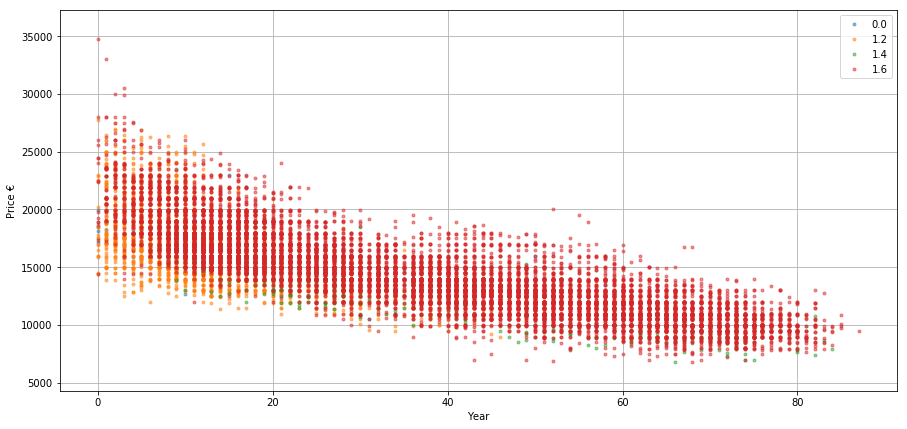

In [46]:
#df_model = func_treatment(df_model,head,year_min)                    # make the treatment of the subdataframe
df_litter = func_outliers(df_model)                                  # clean the data
print('The initial size was {} and the final size is {} rows \n'.format(len(df_model), len(df_litter)))
litter = df_litter[head[7]].unique()                                 # make a list of all the litter types

# ---- Plot the result ------------------------------------------------------

litter.sort()
fig = plt.figure(figsize=(15,7))
#plt.plot_date(df_model.Date, df_model.PRIX, 'b+', alpha=0.8, label='Data')
for i in litter:                                                     # loop on the litter     
    if type(i)==str:                                                 # test on the type, if nan appear -> np.float64
        df_litter1 = df_litter[df_litter[head[7]]==i]                # select the subsubdataframe
    else:
        df_litter1 = df_litter[df_litter[head[7]].isnull()]          # select all the nan rows 
    plt.plot(df_litter1.Age_months, df_litter1.PRIX,  '.', alpha=0.5, label=i)
plt.ylim(df_litter.PRIX.min()-2500, df_litter.PRIX.max()+2500)       # resize the figure 
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

The litter seems to be a good indicator for the dispersion. 

<span style="color:green"><font size="3"><i>d - Model & Power </i></font></span>

Now, try with the power of the car. 

The initial size was 34487 and the final size is 19151 rows 



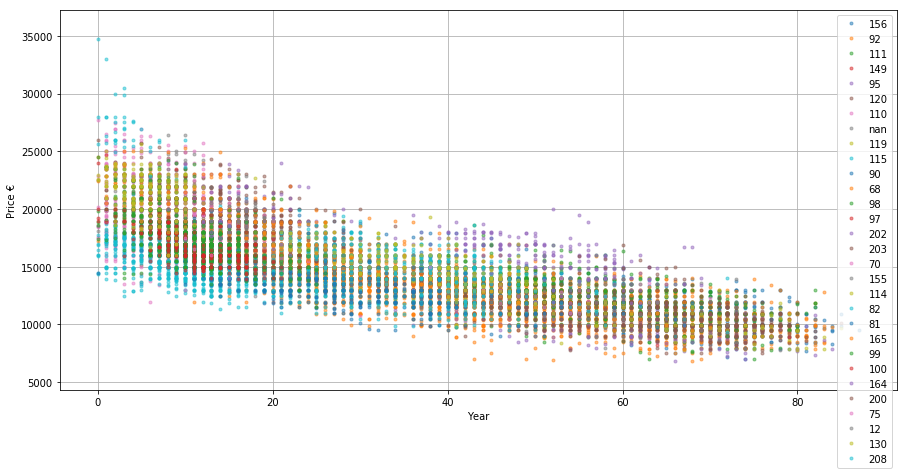

In [47]:
#df_model = func_treatment(df_model,head,year_min)                  # make the treatment of the subdataframe
df_power = func_outliers(df_model)                                 # clean the data
print('The initial size was {} and the final size is {} rows \n'.format(len(df_model), len(df_power)))
power = df_power[head[8]].unique()                                 # make a list of all the power types

# ---- Plot the result ------------------------------------------------------

fig = plt.figure(figsize=(15,7))
#plt.plot_date(df_model.Date, df_model.PRIX, 'b+', alpha=0.8, label='Data')
for i in power:                                                    # loop on the power    
    if type(i)==str:                                               # test on the type, if nan appear -> np.float64
        df_power1 = df_power[df_power[head[8]]==i]                 # select the subsubdataframe
    else:
        df_power1 = df_power[df_power[head[8]].isnull()]           # select all the nan rows 
    plt.plot(df_power1.Age_months, df_power1.PRIX,  '.', alpha=0.5, label=i)
plt.ylim(df_power.PRIX.min()-2500, df_power.PRIX.max()+2500)       # resize the figure 
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

The figure show that the power as no impact on the price or the behavior. 

<span style="color:green"><font size="3"><i>e - Model & gearbox </i></font></span>

Newt test with the gearbox. 

The initial size was 34487 and the final size is 19151 rows 



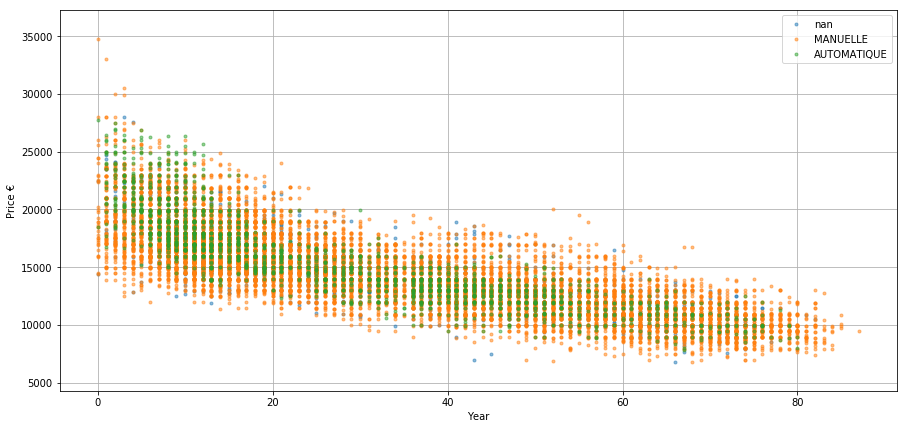

In [48]:
#df_model = func_treatment(df_model,head,year_min)                  # make the treatment of the subdataframe
df_gearbox = func_outliers(df_model)                               # clean the data
print('The initial size was {} and the final size is {} rows \n'.format(len(df_model), len(df_gearbox)))
gearbox = df_gearbox[head[9]].unique()                               # make a list of all the gearbox types

# ---- Plot the result ------------------------------------------------------

fig = plt.figure(figsize=(15,7))
#plt.plot_date(df_model.Date, df_model.PRIX, 'b+', alpha=0.8, label='Data')
for i in gearbox:                                                  # loop on the gearbox   
    if type(i)==str:                                               # test on the type, if nan appear -> np.float64
        df_gearbox1 = df_gearbox[df_gearbox[head[9]]==i]           # select the subsubdataframe
    else:
        df_gearbox1 = df_gearbox[df_gearbox[head[9]].isnull()]     # select all the nan rows 
    plt.plot(df_gearbox1.Age_months, df_gearbox1.PRIX,  '.', alpha=0.5, label=i)
plt.ylim(df_gearbox.PRIX.min()-2500, df_gearbox.PRIX.max()+2500)   # resize the figure
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

The figure show that the gearbox as no impact on the price or the behavior. 

<span style="color:blue"><font size="4">3 - Impact of the litter</font></span>

If the litter parameter has a real impact, it's interesting to select subdataframes for each litter, practice the mean/median and compute a polynomial fit. Then, compute the devalo. 

The initial size was 34487 and the final size is 19151 rows 



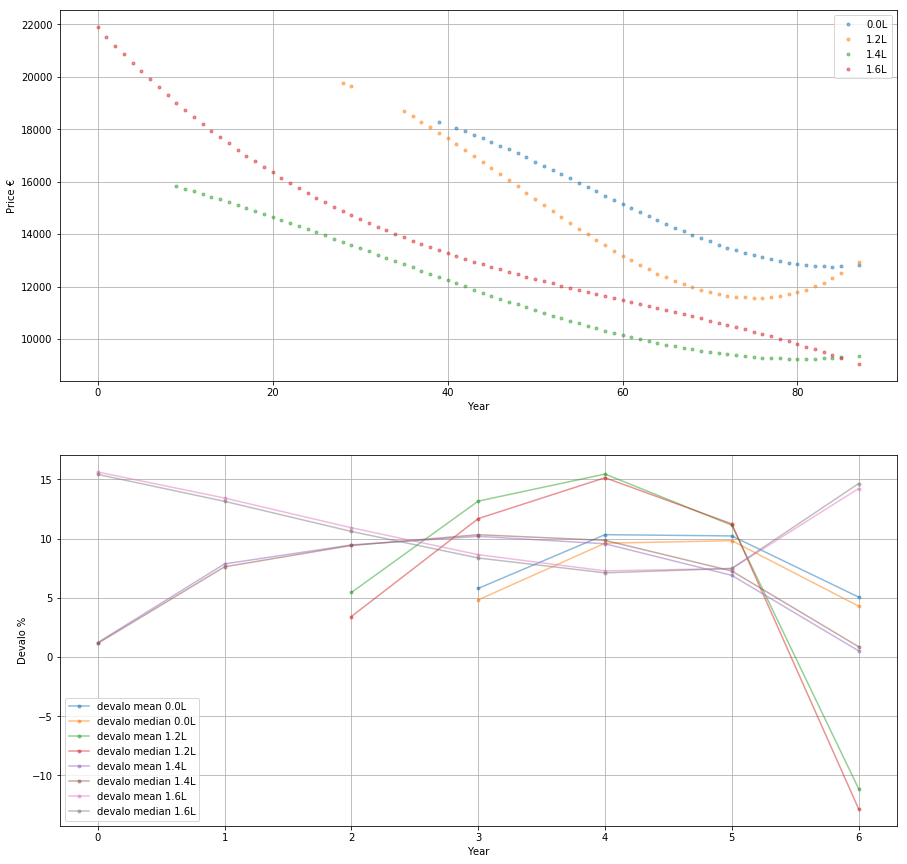

In [49]:
#df_model = func_treatment(df_model,head,year_min)                    # make the treatment of the subdataframe
df_litter = func_outliers(df_model)                                  # clean the data
print('The initial size was {} and the final size is {} rows \n'.format(len(df_model), len(df_litter)))
litter = df_litter[head[7]].unique()                                 # make a list of all the litter types

# ---- Plot the result ------------------------------------------------------

litter.sort()
fig = plt.figure(figsize=(15,15))                                    # Size of the fig 

for i in litter:                                                     # loop on the litter   
    
    if type(i)==str:                                                 # test on the type, if nan appear -> np.float64
        df_litter1 = df_litter[df_litter[head[7]]==i]                # select the subsubdataframe
        df_lit = func_mean_median(df_litter1, 'Age_months')                        # Compute mean median for the litter
        #df_lit = func_reverse(df_lit)                                # Compute the reverse and projected date 
        df_lit, coeff_mean, coeff_median = func_polyfit(df_lit, 3)   # Compute the polyfit with degree 3 
        devalo_poly_mean, df_modif_poly = func_annual_devalo2(df_lit, 'y_poly_mean')     # compute the mean devalo
        devalo_poly_median, df_modif_poly = func_annual_devalo2(df_lit, 'y_poly_median') # compute the median devalo
    else:
        df_litter1 = df_litter[df_litter[head[7]].isnull()]          # select all nan rows 
        df_lit = func_mean_median(df_litter1, 'Age_months')
        #df_lit = func_reverse(df_lit)
        df_lit, coeff_mean, coeff_median = func_polyfit(df_lit, 3)
        devalo_poly_mean, df_modif_poly = func_annual_devalo2(df_lit, 'y_poly_mean')
        devalo_poly_median, df_modif_poly = func_annual_devalo2(df_lit, 'y_poly_median')
        
    ax = plt.subplot(211)                                            # create more than one plot 
    plt.plot(df_lit.Age_months, df_lit.y_poly_mean,  '.', alpha=0.5, label=i+'L')    
    #plt.ylim(df_lit.y_poly_mean.min()-2500, df_lit.y_poly_mean.max()+2500)       # resize the figure 
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Price €')
    plt.grid(True)
    
    ax2 = plt.subplot(212)
    plt.plot(df_modif_poly.annee.unique(), devalo_poly_mean,  '.-', alpha=0.5, label='devalo mean'+' '+i+'L')
    plt.plot(df_modif_poly.annee.unique(), devalo_poly_median,  '.-', alpha=0.5, label='devalo median'+' '+i+'L')    
    
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Devalo %')
    plt.grid(True)

<span style="color:red"><font size="5">VI - Multi-parameters</font></span>

<span style="color:blue"><font size="4">1 - Model-fuel-carbody</font></span>

In [50]:
# ---- This section is for animated plot
import plotly.plotly as py                                         # Animated plot 
from plotly.grid_objs import Grid, Column
from plotly.tools import FigureFactory as FF 

The initial size was 34487 and the final size is 19151 rows 

['BERLINE']
['ESSENCE' 'DIESEL' 'ESSENCE - GPL']
BERLINE ESSENCE
7724 - 40.33 %


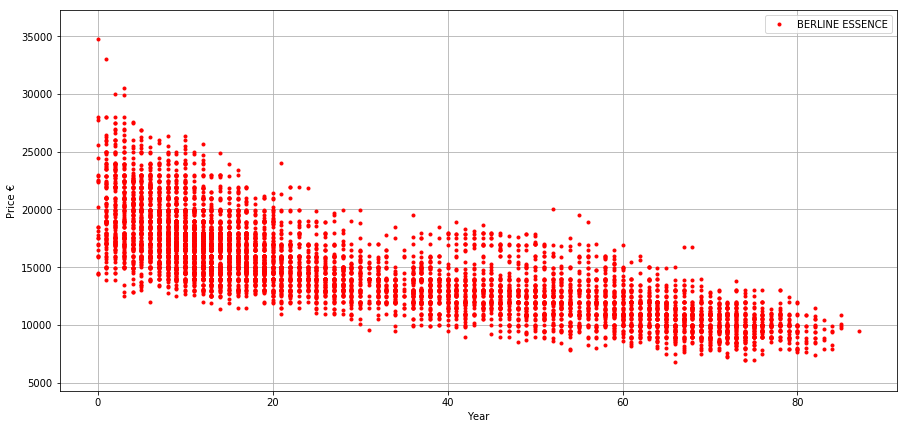

In [51]:
#df_model = func_treatment(df_model,head,year_min)                  # make the treatment of the subdataframe
df_carbody = func_outliers(df_model)                               # clean the data
print('The initial size was {} and the final size is {} rows \n'.format(len(df_model), len(df_gearbox)))
carbody = df_carbody[head[5]].unique()                             # make a list of all the car body types
fuel    = df_carbody[head[6]].unique()                             # make a list of all the fuel types
print(carbody)
print(fuel)
# ---- Plot the result ------------------------------------------------------
numb1 = 0
numb2 = 0
fig = plt.figure(figsize=(15,7))
print(carbody[numb1], fuel[numb2])
#plt.plot(df_model.Age_months, df_model.PRIX, 'b+', alpha=0.8, label='Data')
#for i in gearbox:                                                  # loop on the car body     
if type(carbody[numb1])==str:                                       # test on the type, if nan appear -> np.float64
    df_carbody1 = df_carbody[df_carbody[head[5]]==carbody[numb1]]   # select the subsubdataframe
    df_carbody1 = df_carbody1[df_carbody1[head[6]]==fuel[numb2]]    # select the subsubdataframe
    print(len(df_carbody1),'-','%.2f'%(100*len(df_carbody1)/len(df_carbody)),'%')
    plt.plot(df_carbody1.Age_months, df_carbody1.PRIX,  'r.', alpha=1, label=carbody[numb1]+' '+fuel[numb2])
else:
    df_carbody1 = df_carbody[df_carbody[head[5]].isnull()]          # select all the nan rows 
    df_carbody1 = df_carbody1[df_carbody1[head[6]]==fuel[numb2]]    # select the subsubdataframe
    plt.plot(df_carbody1.Age_months, df_carbody1.PRIX,  'r.', alpha=1, label='NaN '+fuel[numb2])
    print(len(df_carbody1),'-','%.2f'%(100*len(df_carbody1)/len(df_carbody)),'%')

#plt.plot_date(df_carbody1.Date, df_carbody1.PRIX,  'y.', alpha=0.8, label=carbody[numb1]+' '+fuel[numb2])
plt.ylim(df_carbody.PRIX.min()-2500, df_carbody.PRIX.max()+2500)    # resize the figure
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

<span style="color:blue"><font size="4">2 - Model-liter-carbody</font></span>

The initial size was 34487 and the final size is 19151 rows 

['BERLINE']
['0.0' '1.2' '1.4' '1.6']
BERLINE 1.6
14046 - 73.34 %


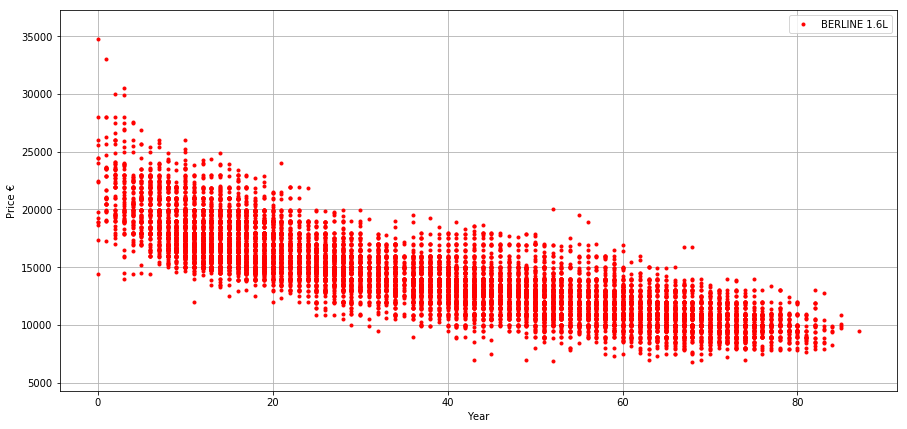

In [52]:
#df_model = func_treatment(df_model,head,year_min)                  # make the treatment of the subdataframe
df_carbody = func_outliers(df_model)                               # clean the data
print('The initial size was {} and the final size is {} rows \n'.format(len(df_model), len(df_gearbox)))
carbody = df_carbody[head[5]].unique()                             # make a list of all the car body types
litter  = df_carbody[head[7]].unique()                             # make a list of all the fuel types
litter.sort()
print(carbody)
print(litter)


# ---- Plot the result ------------------------------------------------------
numb1 = 0
numb2 = 3
fig = plt.figure(figsize=(15,7))
print(carbody[numb1], litter[numb2])
#plt.plot(df_model.Age_months, df_model.PRIX, 'b+', alpha=0.8, label='Data')
#for i in gearbox:                                                  # loop on the car body     
if type(carbody[numb1])==str:                                       # test on the type, if nan appear -> np.float64
    df_carbody1 = df_carbody[df_carbody[head[5]]==carbody[numb1]]   # select the subsubdataframe
    df_carbody1 = df_carbody1[df_carbody1[head[7]]==litter[numb2]]  # select the subsubdataframe
    print(len(df_carbody1),'-','%.2f'%(100*len(df_carbody1)/len(df_carbody)),'%')
    plt.plot(df_carbody1.Age_months, df_carbody1.PRIX,  'r.', alpha=1, label=carbody[numb1]+' '+litter[numb2]+'L')
else:
    df_carbody1 = df_carbody[df_carbody[head[5]].isnull()]          # select all the nan rows 
    df_carbody1 = df_carbody1[df_carbody1[head[7]]==litter[numb2]]  # select the subsubdataframe
    plt.plot(df_carbody1.Age_months, df_carbody1.PRIX,  'r.', alpha=1, label='NaN '+litter[numb2]+'L')
    print(len(df_carbody1),'-','%.2f'%(100*len(df_carbody1)/len(df_carbody)),'%')
plt.ylim(df_carbody.PRIX.min()-2500, df_carbody.PRIX.max()+2500)    # resize the figure
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)